# Desagregación

Implementación del modelo mejor evaluado en la etapa de validación, correspondiente al modelo FHMM entrenado con datos promedio de potencia activa recopilados cada 10 minutos

Librerías y otros ajustes:

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.utils import print_dict

labels = ['Main_RST', 'Lights_1','Lights_2', 'HVAC_1', 'HVAC_2', 'HVAC_4', 'Rack', 'Others']
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan','tab:grey']

## Set de Pruebas

In [2]:
test = DataSet('C:/data/DEPS2.h5')
test.set_window(start="2020-02-24 00:00:00", end="2020-02-25 00:00:00")
test_elec=test.buildings[1].elec # Todos los medidores
test_Main=test_elec.mains() #medidor de cabecera
test_Main

ElecMeter(instance=1, building=1, dataset='DEPS', site_meter, appliances=[])

In [3]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='DEPS', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='DEPS', appliances=[])
  ElecMeter(instance=3, building=1, dataset='DEPS', appliances=[])
  ElecMeter(instance=4, building=1, dataset='DEPS', appliances=[])
  ElecMeter(instance=5, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DEPS', appliances=[Appliance(type='light', instance=2)])
  ElecMeter(instance=7, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=8, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=9, building=1, dataset='DEPS', appliances=[Appliance(type='air conditioner', instance=3)])
  ElecMeter(instance=10, building=1, dataset='DEPS', appliances=[Appliance(type='server computer', instance=1)])
)

Señal original vs señal desagregada

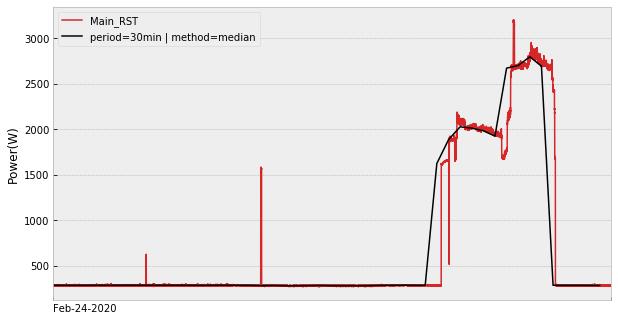

In [4]:
rcParams['figure.figsize'] = (10, 6)

ax1 = next(test_Main.load(ac_type='active', sample_period=1, resample_kwargs={'how':'first'})).plot(c='tab:red', lw=1.5) 
next(test_Main.load(ac_type='active', sample_period=1800, resample_kwargs={'how':'median'})).plot(ax=ax1, c='k', lw=1.5) 

ax1.legend([('Main_RST'),'period=30min | method=median'], loc='upper left') #etiquetas
ax1.minorticks_off()   
ax1.set_ylabel('Power(W)')
ax1.set(xticks=('2020-02-24 00:00:00+01:00', '2020-02-25 00:00:00+01:00'))
ax1.set_xticklabels(labels=['Feb-24-2020'], ha='left', rotation=0)    
plt.savefig('C:/data/images/6.1_Plot_test_30min.svg', bbox_inches='tight', transparent=True)
pass

## Desagregación

In [5]:
from nilmtk.legacy.disaggregate import FHMM
from nilmtk import HDFDataStore

FHMM_test=FHMM()
FHMM_test.import_model('C:/data/FHMM_30min_median_model.pickle') #modelo FHMM elegido
FHMM_test.MIN_CHUNK_LENGTH=1

output=HDFDataStore('C:/data/test_results.h5', 'w')
FHMM_test.disaggregate(test_Main,
                       output,
                       ac_type='active',  #potencia activa, por defecto
                       sample_period=1800, #muestreo 10 minutos
                       resample_kwargs={'how':'median'}) #método first

output.close()
print('\nDone!')


Done!


### Resultados

In [32]:
results=DataSet('C:/data/test_results.h5')
results_elec=results.buildings[1].elec # Todos los medidores
results_Main=results_elec.mains() #medidor de cabecera
results_Devices=results_elec.submeters() #predicciones

results_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='FHMM', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='FHMM', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='FHMM', appliances=[Appliance(type='light', instance=2)])
  ElecMeter(instance=7, building=1, dataset='FHMM', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=8, building=1, dataset='FHMM', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=9, building=1, dataset='FHMM', appliances=[Appliance(type='air conditioner', instance=3)])
  ElecMeter(instance=10, building=1, dataset='FHMM', appliances=[Appliance(type='server computer', instance=1)])
)

### Metadatos

In [9]:
print_dict(results.metadata)

In [10]:
print_dict(results.buildings[1].metadata)

In [12]:
print_dict(results_elec[1].get_metadata())

## Análisis Gráfico

### Todos los resultados

6/6 ElecMeter(instance=10, building=1, dataset='FHMM', appliances=[Appliance(type='server computer', instance=1)])

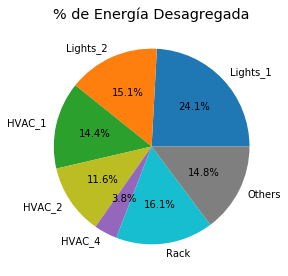

In [42]:
d1=results_elec.fraction_per_meter_2()
ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie',
            labels=labels[1:]+list(['Others']), figsize=(4.5,4.5),
            colors=colors)
ax1.set(ylabel="")
ax1.set(title='% de Energía Desagregada')
#guarda gráfico
plt.savefig('C:/data/images/6.2_Plot_results_1.1.svg', bbox_inches='tight', transparent=True)

6/6 ElecMeter(instance=10, building=1, dataset='FHMM', appliances=[Appliance(type='server computer', instance=1)])

[Text(0.5, 1.0, 'Pred')]

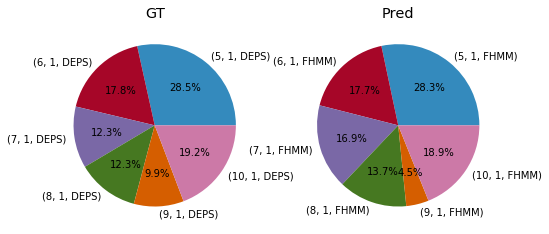

In [40]:
rcParams['figure.figsize'] = (8, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)
test_elec.select(instance=[5,6,7,8,9,10]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
results_elec.select(instance=[5,6,7,8,9,10]).fraction_per_meter().plot(ax=ax2, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
ax1.set(ylabel="")
ax1.set(title='GT')
ax2.set(ylabel="")
ax2.set(title='Pred')

(-100, 3200)

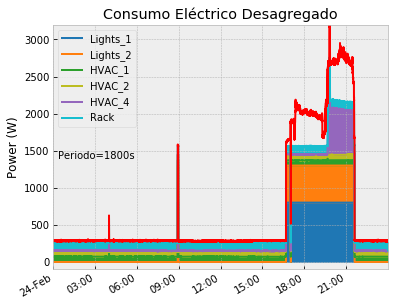

In [84]:
rcParams['figure.figsize'] = (6, 5)

df_d=test_elec.select(instance=[5,6,7,8,9,10]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(test_elec[1].load(ac_type='active')).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['24-Feb','03:00', '06:00', '09:00','12:00','15:00','18:00', '21:00','23:59'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,3200)

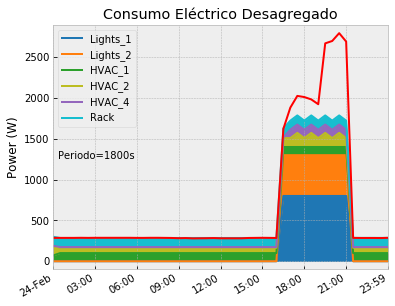

In [79]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[5,6,7,8,9,10]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(results_elec[1].load()).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['24-Feb','03:00', '06:00', '09:00','12:00','15:00','18:00', '21:00','23:59'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2900)
#guarda gráfico
plt.savefig('C:/data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)
pass

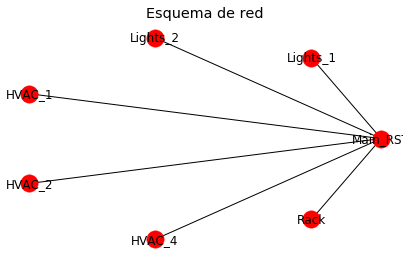

In [71]:
import networkx as nx
rcParams['figure.figsize'] = (5.5, 3.2)

fig = results_elec.draw_wiring_graph_2(show_meter_labels=False)

#etiquetas, opcional
Meters={}

Meters[results_elec[1]]=labels[0]
for x in range(len(labels)-2): Meters[results_elec[x+5]]=labels[x+1]

pos = nx.shell_layout(fig[0])
nx.draw_networkx_labels(fig[0], pos, labels=Meters)

fig[1].set(title='Esquema de red')

#guarda gráfico
plt.savefig('C:/data/images/6.4_Plot_network_1.3.svg', bbox_inches='tight', transparent=True)
pass

In [86]:
#Energía de dispositivos
e_d=round(results_elec.energy_per_meter().transpose()['active'][1:],1)
print('\n\nEnergía de Dispositivos:')
print(e_d)

#Energía total de dispositivos
e_t=round(sum(e_d),2)
print('\nEnergía Total Dispositivos: '+str(e_t))

#energía medida por Mains_RST
e_m=round(results_elec.mains().total_energy(),1)
print('\nEnergía Mains_RST: '+str(e_m[0]))

#energía no medida
print('\nEnergía No medida: '+str(e_m[0]-e_t))

7/7 ElecMeter(instance=10, building=1, dataset='FHMM', appliances=[Appliance(type='server computer', instance=1)])

Energía de Dispositivos:
(5, 1, FHMM)     4.0
(6, 1, FHMM)     2.5
(7, 1, FHMM)     2.4
(8, 1, FHMM)     1.9
(9, 1, FHMM)     0.6
(10, 1, FHMM)    2.7
Name: active, dtype: float64

Energía Total Dispositivos: 14.1

Energía Mains_RST: 16.6

Energía No medida: 2.5000000000000018


In [ ]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[5,6,7,8,9,10]).dataframe_of_meters(ac_type='active')

ax1 = df_d.plot(kind='area',color=colors)   
#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['24-Feb','03:00', '06:00', '09:00','12:00','15:00','18:00', '21:00','23:59'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2000)
#guarda gráfico
#plt.savefig('C:/data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)